In [1]:
import pandas as pd
import chess
import chess.pgn
import io
import numpy as np
import re
import operator
import matplotlib.pyplot as plt

Isolation des coups d'un joueur, analyse de son style, pour une partie 

In [2]:

df = pd.DataFrame(columns=['Opening', 'Result'])
games = open('lichess_elite_2020-06.pgn')
d={}
for k in range(4) :
   game = chess.pgn.read_game(games)
print(game)


[Event "Rated Blitz game"]
[Site "?"]
[Date "2020.06.01"]
[Round "-"]
[White "DanielaAndrade"]
[Black "Dapsay"]
[Result "0-1"]
[BlackElo "2416"]
[BlackRatingDiff "+5"]
[BlackTitle "IM"]
[ECO "D52"]
[LichessURL "https://lichess.org/ZZiTCh8x"]
[Opening "Queen's Gambit Declined"]
[Termination "Time forfeit"]
[TimeControl "180+0"]
[UTCDate "2020.06.01"]
[UTCTime "00:00:19"]
[WhiteElo "2387"]
[WhiteRatingDiff "-5"]

1. d4 d5 2. c4 c6 3. Nc3 Nf6 4. Nf3 e6 5. Bg5 Nbd7 6. e3 Be7 7. Qc2 a6 8. Rd1 h6 9. Bh4 O-O 10. c5 Ne8 11. Bxe7 Qxe7 12. Be2 e5 13. O-O e4 14. Nd2 f5 15. b4 Ndf6 16. f4 exf3 17. Rxf3 Ng4 18. Nf1 g6 19. Bd3 h5 20. Re1 Nef6 21. h3 Nh6 22. Qf2 Kg7 23. Qh4 Bd7 24. Ne2 Rae8 25. Nf4 Nf7 26. Qg3 g5 27. h4 g4 28. Rf2 Bc8 29. Rb2 Kh6 30. Reb1 Ne4 31. Bxe4 Qxe4 32. a4 Bd7 33. Qf2 Nd8 34. Ng3 Qxe3 35. Ngxh5 Re4 36. Qxe3 Rxe3 37. Kf2 Re4 38. Rd1 Ne6 39. Nxe6 Bxe6 40. Ng3 f4 41. Nxe4 dxe4 42. g3 e3+ 43. Ke2 Bc4+ 44. Rd3 Kh5 45. gxf4 Rxf4 46. Rc2 Rf2+ 47. Kxe3 Rxc2 48. Rd1 Bd5 49. Kf4 Rf2+ 50

In [3]:
#Nettoyage et isolation des données importantes, c'est à dire les coups trier par ligne colonne pièce et occurence
games = open('lichess_elite_2020-06.pgn')
d={}
board = game.board()
for k in range(1) :
   game = chess.pgn.read_game(games)
def iso_move (game,iswhite=True):
    b=[]
    whitemove = []
    blackmove = []
    freq = {}
    for move in game.mainline_moves():
        b.append(board.san(move))
        board.push(move)

    for i in range(0, len(b)):
        if i % 2:
            blackmove.append(b[i])
        else :
            whitemove.append(b[i])
    
    blackmovestr = ' '.join(blackmove)    
    whitemovestr = ' '.join(whitemove)  
    
    def check_freq(a):
        for c in set(a):
            freq[c] = a.count(c)
        return freq
    blackm=check_freq(blackmovestr)
    whitem=check_freq(whitemovestr)
    def clean_data(x): 
        if ' ' in x : 
            x.pop(' ')
        if '-' in x :   
            x.pop('-')
        if 'x' in x : 
            x.pop('x')
        if '+' in x : 
            x.pop('+')
        if 'O' in x : 
            x.pop('O')
    clean_data(blackm)
    clean_data(whitem)
    def tabl_move(x) :
        df=pd.DataFrame(list(x.items()),columns=['Position', 'Mouvement'])
        df.sort_values(by = 'Position')
        df1=df.loc[df['Position'].str.contains('[A-Z]')]
        df2=df.loc[df['Position'].str.contains('[a-z]')]
        df3=df.loc[df['Position'].str.contains('[0-9]')]
        df1 = df1.rename(columns={'Position':'Piece'})
        df2 = df2.rename(columns={'Position':'Ligne'})
        df3 = df3.rename(columns={'Position':'Colonne'})
        df1=df1.sort_values(by = 'Piece')
        df2=df2.sort_values(by = 'Ligne')
        df3=df3.sort_values(by = 'Colonne')
        df1.reset_index(inplace=True, drop = True)
        df2.reset_index(inplace=True, drop = True)
        df3.reset_index(inplace=True, drop = True)
        return df1, df2, df3 
    return  tabl_move(whitem) if iswhite else tabl_move(blackm)

In [5]:
#exemple de sortie 
board = game.board()
ar1 = np.array([['B',0], ['K',0], ['N',0], ['Q',0], ['R',0]])
df1bT= pd.DataFrame(ar1, columns = ['Piece', 'Mouvement'])
df1b, df2b, df3b= iso_move(game,False)  
df1bT = pd.concat( [df1bT, df1b],axis=0,ignore_index=True)
df1bT["Mouvement"] = pd.to_numeric(df1bT["Mouvement"])
df11wT = df1bT.groupby('Piece')['Mouvement'].sum().reset_index()
df11wT


,Piece,Mouvement
0,B,4
1,K,0
2,N,5
3,Q,2
4,R,0


In [10]:
# Extraction des données de 100 parties pour un joueur précis du nom de Lampertcity alias Hippolyte Sibileau, 
# seulement sera retenu les parties que Lampertcity perd pour savoir si une méthode de victoire apparait 
pgn = open('lichess_lampertcity_2022-10-27.pgn')
board = game.board()
ar1 = np.array([['B',0], ['K',0], ['N',0], ['Q',0], ['R',0]])
ar2 = np.array([['a',0], ['b',0], ['c',0], ['d',0], ['e',0],['f',0],['g',0],['h',0],])
ar3 = np.array([['1',0], ['2',0], ['3',0], ['4',0], ['5',0],['6',0],['7',0],['8',0]])
df1wT= pd.DataFrame(ar1, columns = ['Piece', 'Mouvement'])
df2wT= pd.DataFrame(ar2, columns = ['Ligne', 'Mouvement'])
df3wT= pd.DataFrame(ar3, columns = ['Colonne', 'Mouvement'])
df1bT= pd.DataFrame(ar1, columns = ['Piece', 'Mouvement'])
df2bT= pd.DataFrame(ar2, columns = ['Ligne', 'Mouvement'])
df3bT= pd.DataFrame(ar3, columns = ['Colonne', 'Mouvement'])
for k in range(100) :
        board = game.board()
        game = chess.pgn.read_game(pgn) 
        if game.headers["White"] == "lampertcity" and game.headers["Result"] == "0-1" : 
                df1w, df2w, df3w = iso_move(game)
                df1wT = pd.concat( [df1wT, df1w],axis=0,ignore_index=True)
                df2wT = pd.concat( [df2wT, df2w],axis=0,ignore_index=True)
                df3wT = pd.concat( [df3wT, df3w],axis=0,ignore_index=True)
                df1wT["Mouvement"] = pd.to_numeric(df1bT["Mouvement"])
                df2wT["Mouvement"] = pd.to_numeric(df2bT["Mouvement"])
                df3wT["Mouvement"] = pd.to_numeric(df3bT["Mouvement"])
                df1wT = df1wT.groupby('Piece').sum().reset_index()
                df2wT = df2wT.groupby('Ligne').sum().reset_index()
                df3wT = df3wT.groupby('Colonne').sum().reset_index()
                
        if game.headers["Black"] == "lampertcity" and game.headers["Result"] == "1-0" : 
        
                df1b, df2b, df3b = iso_move(game, False)
                df1bT = pd.concat( [df1bT, df1b],axis=0,ignore_index=True)
                df2bT = pd.concat( [df2bT, df2b],axis=0,ignore_index=True)
                df3bT = pd.concat( [df3bT, df3b],axis=0,ignore_index=True)
                df1bT["Mouvement"] = pd.to_numeric(df1bT["Mouvement"])
                df2bT["Mouvement"] = pd.to_numeric(df2bT["Mouvement"])
                df3bT["Mouvement"] = pd.to_numeric(df3bT["Mouvement"])
                df1bT = df1bT.groupby('Piece').sum().reset_index()
                df2bT = df2bT.groupby('Ligne').sum().reset_index()
                df3bT = df3bT.groupby('Colonne').sum().reset_index()
df11=pd.concat([df1wT, df1bT],axis=0,ignore_index=True)
df22=pd.concat([df2wT, df2bT],axis=0,ignore_index=True)
df33=pd.concat([df3wT, df3bT],axis=0,ignore_index=True)
df11 = df11.groupby('Piece').sum().reset_index()
df22 = df22.groupby('Ligne').sum().reset_index()
df33 = df33.groupby('Colonne').sum().reset_index()
df22

,Ligne,Mouvement
0,a,120.0
1,b,178.0
2,c,280.0
3,d,340.0
4,e,358.0
5,f,302.0
6,g,246.0
7,h,152.0


<AxesSubplot:xlabel='Colonne'>

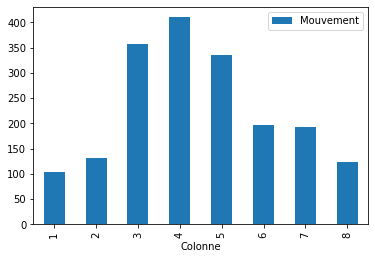

In [235]:
#Visualisation des données -- Mouvemeent en fonction des colonnes 
df33.plot('Colonne', 'Mouvement', kind='bar')

<AxesSubplot:xlabel='Ligne'>

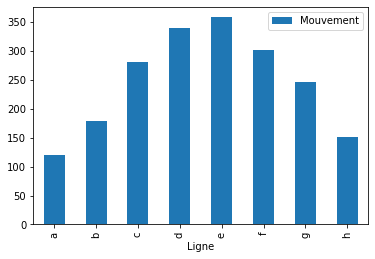

In [236]:
#Visualisation des données -- Mouvemeent en fonction des lignes
df22.plot('Ligne', 'Mouvement', kind='bar')

<AxesSubplot:xlabel='Piece'>

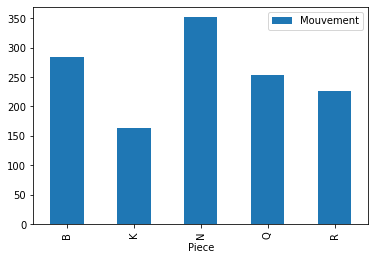

In [238]:
#Visualisation des données -- Mouvemeent en fonction des pièces
df11.plot('Piece', 'Mouvement', kind='bar')